In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


c:\Users\prath\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


* Get the stock data from Yahoo finance as a CSV for any company. 
* Drop all other columns (Volume, Year, Month and Day) and retain Open, High and Close - since I'm just predicting the close value for a day

In [3]:
# Load the data
df = pd.read_csv("historic_data/csv/TCS.NS.csv")

# Remove rows where volume is 0
df = df[df["Volume"] != 0]

# Convert the date column to ordinal values
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Drop rows with NaN or infinite values
df = df.replace([np.inf, -np.inf], np.nan) # replace inf values with NaN                                                                                                                                                                                                                                                            
df = df.dropna() # drop rows with NaN values

# Convert the date column to ordinal values
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].apply(lambda date: date.toordinal())
# Split the data into features (X) and target (y)
X = df.drop("Adjusted Close", axis=1)
y = df["Adjusted Close"]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()
y_train = y_train.sort_index()
y_test


10        30.242895
14        31.606146
16        30.431229
24        29.408785
25        28.834774
           ...     
5119    3371.850098
5123    3281.949951
5124    3214.949951
5140    3263.399902
5150    3176.000000
Name: Adjusted Close, Length: 968, dtype: float64

<h2>Normalizing and removing the null data points</h2>

In [4]:
# Train the model
# Create the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)


<h2>Predicted Values</h2>

31/31 [==============================] - 0s 3ms/step


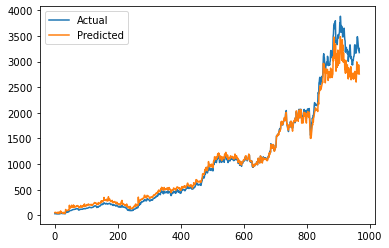

In [8]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Plot the actual vs predicted values
import matplotlib.pyplot as plt
plt.plot(y_test.values)
plt.plot(y_pred)
plt.legend(["Actual", "Predicted"])
plt.show()



Execute the trained model

31/31 [==============================] - 0s 6ms/step


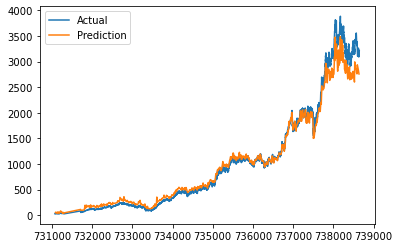

In [9]:
# Convert X_train and X_test to pandas dataframes
X_train = pd.DataFrame(X_train, columns=df.columns[:-1])
X_test = pd.DataFrame(X_test, columns=df.columns[:-1])

# # Convert the date column to datetime and ordinal values
# X_train["Date"] = pd.to_datetime(X_train["Date"], format="%Y-%m-%d")
# X_train["Date"] = X_train["Date"].apply(lambda date: date.toordinal())
# X_test["Date"] = pd.to_datetime(X_test["Date"], format="%Y-%m-%d")
# X_test["Date"] = X_test["Date"].apply(lambda date: date.toordinal())

# Sort X_test by date and make predictions
X_test = X_test.sort_values(by="Date")
y_pred = model.predict(X_test)

# Plot the prediction and actual values
plt.plot(df["Date"], df["Adjusted Close"], label="Actual")
plt.plot(X_test["Date"], y_pred, label="Prediction")
plt.legend()
plt.show()


In [11]:
# Plot the prediction and actual values
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["Date"], y=df["Adjusted Close"], name="Actual"))
fig.add_trace(go.Scatter(x=X_test["Date"], y=y_pred, name="Prediction"))
fig.update_layout(title="Actual vs Prediction", xaxis_title="Date", yaxis_title="Adjusted Close")
fig.show()


In [12]:
import numpy as np

y_pred = y_pred[-100:]
adjusted_close = df["Adjusted Close"][-100:]

adjusted_close = adjusted_close.values.reshape(-1, 1)  # Convert to NumPy array and reshape to (100, 1)

error = 0
for i in range(len(y_pred)):
    error += np.abs(y_pred[i] - adjusted_close[i])** 2

mse = (error/ len(y_pred))** 0.5
print("Mean Squared Error:", mse)


Mean Squared Error: [422.79758388]


In [16]:

# Predict the next two days
last_date = df['Date'].max()
next_date = last_date + 1
next_pred = mse + model.predict([[next_date, X_test["Low"].iloc[-1], X_test["Open"].iloc[-1], X_test["Volume"].iloc[-1], X_test["High"].iloc[-1], X_test["Close"].iloc[-1]]])
next_date = next_date + 1
next_pred_2 =mse + model.predict([[next_date, X_test["Low"].iloc[-1], X_test["Open"].iloc[-1], X_test["Volume"].iloc[-1], X_test["High"].iloc[-1], next_pred[0][0]]])
print("Predictions for the next two days:", next_pred[0][0], next_pred_2[0][0])

1/1 [==============================] - 0s 224ms/step
Predictions for the next two days: 3180.89694911666 3181.523169819785


In [17]:
import pickle

# Save the predicted values in a file
with open('ann.pkl', 'wb') as f:
    pickle.dump([next_pred[0][0], next_pred_2[0][0]], f)
